In [ ]:
root_dir = '/content/drive/MyDrive/TimeseriesPrediction'
data_dir = '/content/drive/MyDrive/data'
# !ls drive/MyDrive/TimeseriesPrediction

import os
import sys
sys.path.append(root_dir)
sys.path.append(data_dir)

In [ ]:
import time
import pickle
import logging

In [ ]:
log_dir = "/content/drive/MyDrive/TimeseriesPrediction/SocialLSTM/2023-03-27 14:09:39" # Specify the directory to continue a previous experiment.

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format="%(name)s - %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(log_dir, 'test-log')),
        logging.StreamHandler()
    ],
    force=True  # without force set, basicConfig not working
)

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import tensorboard

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from timeseries_dataset import TimeSeriesDataset
from lstm_models import LSTM, SocialLSTM # renamed 
from solver import Solver

numexpr.utils - NumExpr defaulting to 2 threads.


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
config_load_file = os.path.join(log_dir, "config.pkl") 
with open(config_load_file, 'rb') as f:
  config = pickle.load(f)

data_config = config['data_config']
model_config = config['model_config']
train_config = config['train_config']

Load test dataset

In [ ]:
power_path = os.path.join(data_dir, "Electricity_P.csv")
weather_path = os.path.join(data_dir, "Climate_HourlyWeather.csv")

In [ ]:
test_dataset = TimeSeriesDataset(power_path, weather_path, 
                                input_len = data_config['input_len'], 
                                output_len = data_config['output_len'],
                                stride = data_config['stride'],
                                scaler = data_config['scaler'],
                                weather_encoder = data_config['weather_encoder'],
                                datetime_encoder = data_config['datetime_encoder'],
                                mode = 'test')
test_dataloader = DataLoader(test_dataset, batch_size=1)

Set up model

In [ ]:
# writer = SummaryWriter('runs/electricity_forecasting')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = SocialLSTM(device=device,
                     input_size=model_config['input_size'],
                     hidden_size=model_config['hidden_size'], 
                     embedding_size=model_config['embedding_size'],
                     num_layer=model_config['num_layer'])
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
model_load_file = os.path.join(log_dir, "models", "model-3")
checkpoint = torch.load(model_load_file, map_location=device)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Evaluate

solver - Eval
solver - Iteration [500]: elapsed time 55.38(s), eval loss 127490.18089
solver - Iteration [1000]: elapsed time 54.56(s), eval loss 149494.85047
solver - Iteration [1500]: elapsed time 54.78(s), eval loss 144742.91158
solver - Iteration [1751]: elapsed time 27.45(s), eval loss 146177.55238
solver - Eval total loss: 146177.55238


146177.552375669

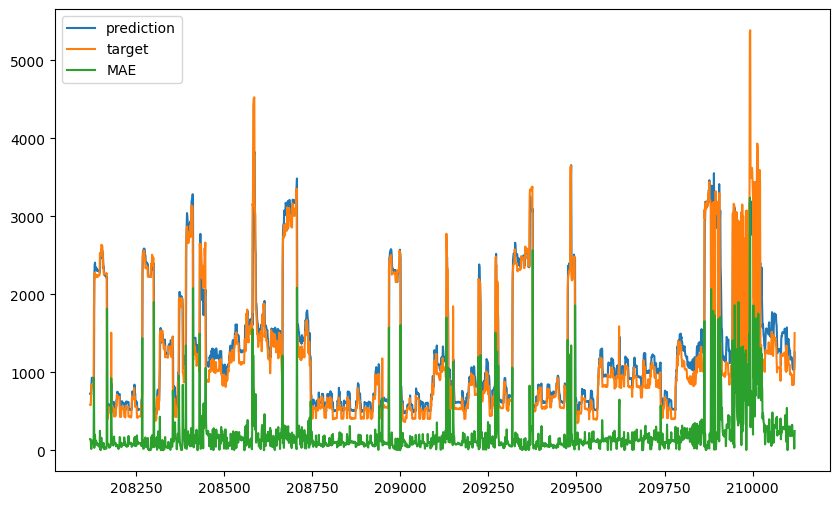

In [ ]:
solver = Solver(model,
          optimizer=None,
          optim_scheduler=None)

solver.evaluate(test_dataloader, 
                train_config['output_scaler'],
                visualize=True)